# Modeling

Now we will begin the process of creating classification models and evaluate their respective performances

In [2]:
#imports
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.preprocessing import LabelEncoder
from library.sb_utils import save_file

### Load our processed data

In [4]:
filepath = '../data/processed/'
X = pd.read_csv(filepath + 'X_pre.csv')
y = pd.read_csv(filepath + 'y_pre.csv')

### Note
Throughout this notebook code for performing the same tests on 2016 and 2017 data are in markdown cells (change to code to run)

2016 and 2017 data is now availible in 

    filepath = '../data/processed/X_pre16.csv'
    filepath = '../data/processed/X_pre17.csv'

    X16 = pd.read_csv(filepath+ 'X_pre16.csv')
    X17 = pd.read_csv(filepath+ 'X_pre17.csv')

    y16 = pd.read_csv(filepath + 'y_pre16.csv')
    y17 = pd.read_csv(filepath + 'y_pre17.csv')

Our final set of predictive features

In [5]:
X

,inning,o,p_score,p_throws,stand,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,1,1,0,L,L,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,0,L,L,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,1,1,0,L,L,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,1,1,0,L,L,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,1,1,0,L,L,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,4,2,0,R,R,0.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0
21576,4,2,0,R,R,0.0,2.0,2.0,1.0,5.0,0.0,0.0,0.0
21577,4,3,0,R,L,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
21578,4,3,0,R,L,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0


In [6]:
y

,pitch_type
0,FF
1,FF
2,FF
3,FF
4,CU
...,...
21575,FF
21576,CH
21577,CH
21578,CH


    X_1516 = X.append(X16)
    y_1516 = y.append(y16)

    X_1516

    y_1516

You can ignore the index being repeated, as it doesn't play a role in the future

    #switch for ease of consistency
    X = X_1516
    y = y_1516

### Encode numerical features

In [15]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [16]:
X_drop = pd.get_dummies(X, drop_first = True)

In [17]:
scaler = StandardScaler()
X_s = scaler.fit_transform(X_drop)

In [18]:
y_encoder = LabelEncoder()

In [19]:
y_array = y.to_numpy().flatten()
y_enc = y_encoder.fit(y_array)

In [20]:
y_enc.classes_

array(['CH', 'CU', 'FC', 'FF', 'FT', 'SI', 'SL'], dtype=object)

In [21]:
y1 = y_enc.transform(y_array)

In [22]:
y1.shape

(21580,)

## Models

### Important note:

Some of the code here is a bit terse as several other notebooks were used throughout the project. Some pursuits which didn't yield any significant contribution (including alot of the hyperparameter tuning), aren't extrememly detailed here. The other "scratchwork" notebooks are in the "notebooks-scratch" folder.

In [23]:
#split data into train and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X_s, y1, test_size = 0.2, random_state = 123, stratify = y1)

For now we will use accuracy as our main metric, while also looking at f1, roc_auc_score, recall and precision. For the latter measures, a weighted average was used. Another note is that due to the nature of the project, we don't have an particular need to worry about false positives or false negatives more than one another, the way we would for something involving medicine or other higher stakes scenarios. 

Lets start by creating a dummy classifier set to always predict the most frequent classification (4 seam fastball, labeled FF, which occurs 42.5% of the time).

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
dumb = DummyClassifier(strategy = 'most_frequent')

In [27]:
dumb.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [28]:
y_pred = dumb.predict(X_test)
dumb.score(X_test, y_test)

0.4263206672845227

In [29]:
from sklearn.metrics import roc_auc_score

In [30]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#verify that accuracy_score and model.score agree
accuracy_score(y_pred, y_test)

0.4263206672845227

In [31]:
y_test

array([1, 6, 0, ..., 1, 6, 3])

In [32]:
dumb.predict_proba(X_test).shape

(4316, 7)

In [33]:
roc_auc_score(y_test, dumb.predict_proba(X_test), multi_class = 'ovo')

0.5

### Here are a couple functions that were created to save time with repetative processes

The function `ez_model` completes several of the tasks that I found myself repetatively writing code for. Depending on the parameters chosen, it can take a sklearn model, fit it with the test data, create a prediction vector, evaluate the metrics of interest and store them in a dictionary, and plot the confusion matrix. 

A smaller function `plot_cm` was also used to plot the confusion matrix and print the f1 and accuracy score for a given model. Most of its use was phased out as those capabilities were added to `ez_model`.

Similarly, the function `ez_mets`allows for a quick look at Recall, Precision, and AUC-ROC-Score, if you do not want to call the `ez_model` function. 



In [75]:
metrics_dict = {'model':[],'accuracy':[], 'recall':[], 'precision':[], 'f1_score' : [], 'roc_auc_score' : []}

def ez_model(model, fit = False, store = True, plot = False, metrics = True, metric_average = 'weighted',\
             hyperparameters = False, SMOTE = False, metric_class = 'ovr',overwrite = False):
    '''
    modeling function 
    '''
    from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,roc_auc_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    if overwrite is False:
        if str(model) in metrics_dict['model']:
            return "model name already present, set 'overwrite' to True, or change name"
        
        
    if fit == True:
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    if store == True:
        metrics_dict['model'].append(str(model)) 
        metrics_dict['accuracy'].append(accuracy_score(predictions,y_test))
        metrics_dict['recall'].append(recall_score(y_test,predictions, average = metric_average))
        metrics_dict['precision'].append(precision_score(y_test, predictions, average = metric_average,zero_division = 0))
        metrics_dict['f1_score'].append(f1_score(y_test,predictions, average = metric_average))
        metrics_dict['roc_auc_score'].append(roc_auc_score(y_test, model.predict_proba(X_test), multi_class = metric_class))
    
    if metrics == True:
        print(str(model))
        print('accuracy ',accuracy_score(predictions,y_test))
        print('Recall ', recall_score(y_test,predictions,average = metric_average))
        print('Precision ', precision_score(y_test,predictions,average = metric_average, zero_division = 0))
        print('f1 ',f1_score(y_test,predictions, average = metric_average))
        print("AUC-ROC-Score ", roc_auc_score(y_test, model.predict_proba(X_test), multi_class = metric_class))
                        
         
                                
    if plot == True:
        fig, ax = plt.subplots(figsize=(8,6))
        predictions = model.predict(X_test)
        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
        disp.plot(ax=ax)                                    

In [35]:
def plot_cm(model):
    fig, ax = plt.subplots(figsize=(8,6))
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
    disp.plot(ax=ax)
    

In [36]:
from sklearn.metrics import recall_score, precision_score
def ez_mets(model):
    preds = model.predict(X_test)
    print('Recall ', recall_score(y_test,preds,average = 'weighted'))
    print('Precision ', precision_score(y_test,preds,average = 'weighted', zero_division = 0))
    print("AUC-ROC-Score ", roc_auc_score(y_test, model.predict_proba(X_test), multi_class = 'ovr'))

In [76]:
ez_model(dumb, metrics = True)

DummyClassifier(strategy='most_frequent')
accuracy  0.4263206672845227
Recall  0.4263206672845227
Precision  0.18174931135392072
f1  0.2548505613396757
AUC-ROC-Score  0.5


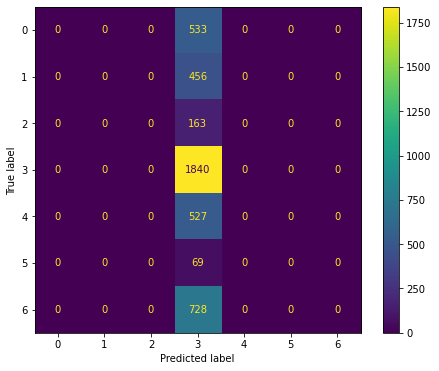

In [77]:
plot_cm(dumb)

In [41]:
ez_mets(dumb)

Recall  0.4263206672845227
Precision  0.18174931135392072
AUC-ROC-Score  0.5


Now we will look at different classifiers and how they perform on our test data. For now, we will not tune any hyperparameters (leave them on default settings). 

### Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

C:\Users\alber\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

LogisticRegression()
accuracy  0.41682113067655235
Recall  0.41682113067655235
Precision  0.2590544767100749
f1  0.2777401609655689
AUC-ROC-Score  0.6776151897807662


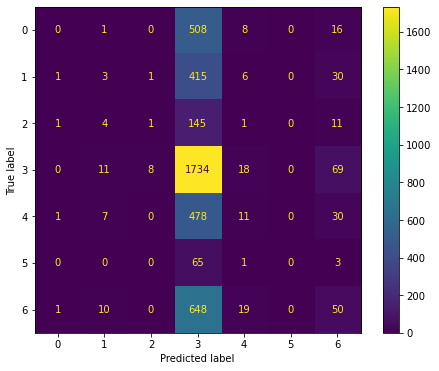

In [79]:
ez_model(lr, metrics = True, plot = True)

In [46]:
lr_dense = lr.decision_function(X_test)

In [47]:
lr_dense

array([[ 1.48129204,  1.31358008, -2.68766975, ...,  0.77959551,
        -5.95907472,  2.28719245],
       [ 0.31181909,  0.71104544, -0.05439222, ...,  0.31901399,
        -1.89769403, -0.23443892],
       [-0.25024411, -0.28490529, -0.88649024, ...,  0.61172884,
        -0.69931786,  0.21982492],
       ...,
       [ 1.60705052,  0.81988648, -1.67023577, ...,  0.77710738,
        -5.59692961,  1.06018725],
       [ 1.78338775,  1.00148123, -1.5937895 , ...,  0.60684077,
        -5.88169667,  1.20900981],
       [ 1.73350618,  1.59070818, -1.61914395, ...,  0.77207545,
        -6.67809818,  1.52292975]])

In [48]:
lr_proba = lr.predict_proba(X_test)
lr_proba.shape


(4316, 7)

In [51]:
s = pd.Series(maxp)
s.describe()

count    4316.000000
mean        0.428044
std         0.123434
min         0.186486
25%         0.326635
50%         0.413153
75%         0.534291
max         0.727546
dtype: float64

In [52]:
lrdf = pd.DataFrame({'prediction':list(lr.predict(X_test)),'prob':s})
lrdf

,prediction,prob
0,3,0.444871
1,3,0.258776
2,3,0.396364
3,3,0.459383
4,3,0.460790
...,...,...
4311,3,0.636703
4312,3,0.355497
4313,3,0.616855
4314,3,0.557548


In [53]:
lrdf['true'] = list(y_test)
lrdf

,prediction,prob,true
0,3,0.444871,1
1,3,0.258776,6
2,3,0.396364,0
3,3,0.459383,3
4,3,0.460790,3
...,...,...,...
4311,3,0.636703,1
4312,3,0.355497,4
4313,3,0.616855,1
4314,3,0.557548,6


In [54]:
ex1 = lrdf[lrdf.prob>0.6]

In [92]:
ex1.shape

(487, 3)

Attempted to only advise when it ruled a probability of 0.6 or higher, accuracy improved to 62.4% but only yielded 487 predictions from an original set of 4316. 

In [55]:
accuracy_score(ex1.prediction.to_numpy(), ex1.true.to_numpy())

0.6242299794661191

In [45]:
ez_mets(lr)

Recall  0.4254287403903016
Precision  0.2822530797256812
AUC-ROC-Score  0.6913697727589802


## Decision Tree Classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier

In [80]:
dt = DecisionTreeClassifier()

In [81]:
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
ez_model(dt,metrics = True, plot = True)

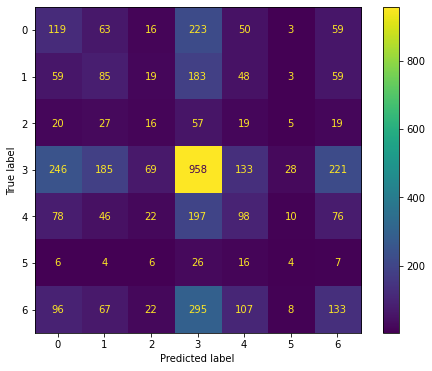

In [59]:
plot_cm(dt)

In [82]:
ez_model(dt, store = True)

DecisionTreeClassifier()
accuracy  0.327386468952734
Recall  0.327386468952734
Precision  0.3224955497464609
f1  0.32407068618985346
AUC-ROC-Score  0.5477664416923969


## Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [84]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [85]:
ez_model(rf, store = True)

RandomForestClassifier()
accuracy  0.3644578313253012
Recall  0.3644578313253012
Precision  0.3248815116895297
f1  0.3379399645767752
AUC-ROC-Score  0.644192358101397


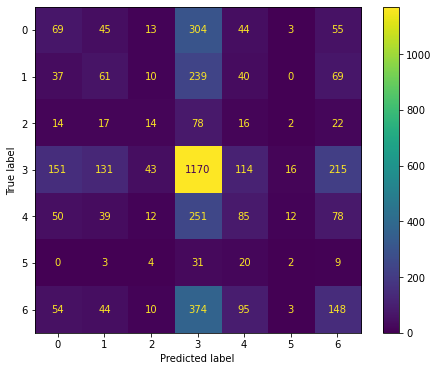

In [64]:
plot_cm(rf)

In [65]:
rf.feature_importances_

array([0.21717324, 0.09002305, 0.17092025, 0.12799685, 0.04693132,
       0.02725067, 0.06712473, 0.09131626, 0.04112497, 0.03665434,
       0.02270406, 0.03577674, 0.02500351])

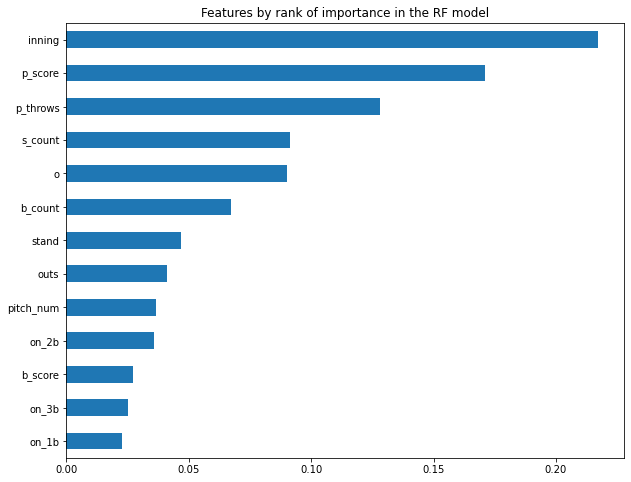

In [66]:
rf_features =  pd.Series(rf.feature_importances_, index = X.columns)

rf_features.sort_values().plot(kind='barh', figsize=(10,8))
plt.title('Features by rank of importance in the RF model')
plt.show()

In [67]:
ez_mets(rf)

Recall  0.3588971269694161
Precision  0.31830254876429
AUC-ROC-Score  0.6433215891664907


The 3 models on default parameter settings have fairly similar accuracy scores, however their confusion matrix shows that they arrived at that score differently. The Logistic Regression model arrived at a score very similar to that of the dummy classifier (set to predict the most_common label), by overwhelmingly predicting the most common label. The dt and rf models both showed a much more balanced set of predictions but with lower accuracy scores.

## Gradient Boosting Classifier

In [86]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()


In [87]:
gb.fit(X_train,y_train)

GradientBoostingClassifier()

GradientBoostingClassifier()
accuracy  0.43721037998146434
Recall  0.43721037998146434
Precision  0.35798715283298044
f1  0.3148368552497716
AUC-ROC-Score  0.7228913164557556


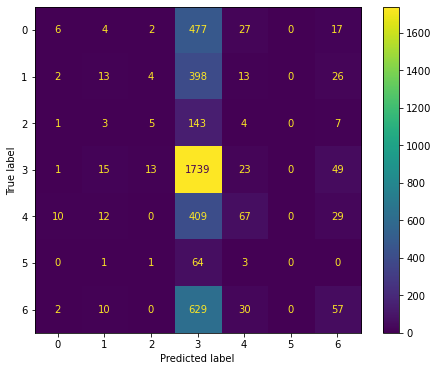

In [88]:
ez_model(gb, store = True, plot = True)

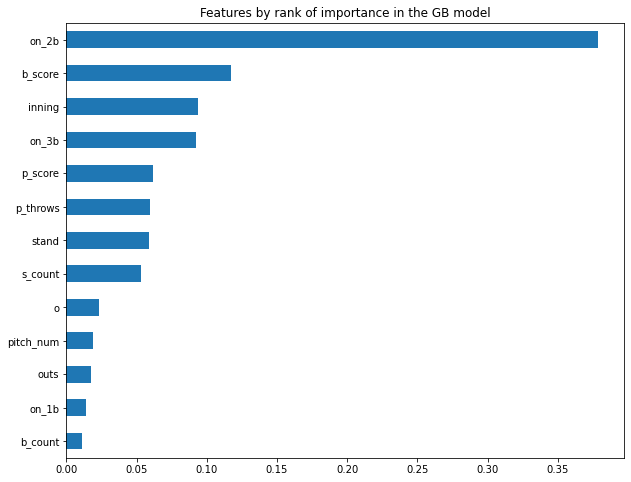

In [70]:
gb_features =  pd.Series(gb.feature_importances_, index = X.columns)

gb_features.sort_values().plot(kind='barh', figsize=(10,8))
plt.title('Features by rank of importance in the GB model')
plt.show()

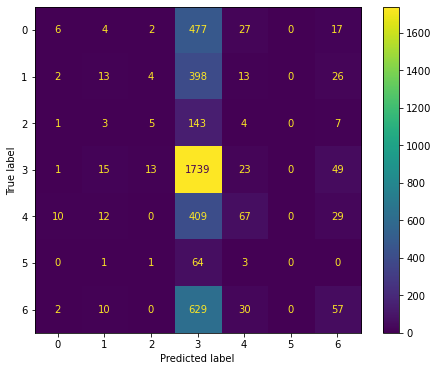

In [71]:
plot_cm(gb)

In [72]:
ez_mets(gb)

Recall  0.43721037998146434
Precision  0.35798715283298044
AUC-ROC-Score  0.7228951160052527


it is very robust (not much changing...) idk if thats good or not. 

In [89]:
metrics = pd.DataFrame(metrics_dict)

In [90]:
metrics

,model,accuracy,recall,precision,f1_score,roc_auc_score
0,DummyClassifier(strategy='most_frequent'),0.426321,0.426321,0.181749,0.254851,0.500000
1,LogisticRegression(),0.416821,0.416821,0.259054,0.277740,0.677615
2,DecisionTreeClassifier(),0.327386,0.327386,0.322496,0.324071,0.547766
3,RandomForestClassifier(),0.364458,0.364458,0.324882,0.337940,0.644192
4,GradientBoostingClassifier(),0.437210,0.437210,0.357987,0.314837,0.722891


Out of the box, the gradient boosting classifier seems to show the most promise out of the 4 non dummy classifiers we tried. The decision tree and random forest both were more "ambitious" with their predictions, having a much more diverse, if less accurate prediction set.

The F1 scores were better on the decision tree and random forest models.
The logistic regression and gradient boosting models both predicted the four seam fastball an overwhelming majority of the time. 

Now we want to work on improving our predictions. 

From here, we can look to improve our model in a couple different ways. We could start experimenting with the hyperparameters of the models, or we could try to go back to our data and either use sampling methods (SMOTE, etc) to train our model on a more evenly distributed set of data, or add data from the original pitch csv files (recall that we started with ~2,500,000 rows, and are now only working with 21,580). 

## SMOTE & Undersampling

In [96]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [97]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler


In [102]:
count_before_resample = Counter(y_train)
count_before_resample

Counter({4: 4143, 1: 3510, 3: 14393, 0: 3915, 6: 6083, 2: 1171, 5: 602})

In [63]:
#lets try the following distribution
strategy1 = {0:2500, 1:2300, 2:900,  4:2500, 5:400, 6:3500}
strategydown = {3:4500}

In [103]:
#for multiyear
strategy16 = {0:5000, 1:4600, 2:1800,  4:5000, 5:800, 6:7000}
strategydown16 = {3:9000}

In [64]:
oversample = SMOTE(sampling_strategy = strategy1)
X_tr, y_tr = oversample.fit_resample(X_train, y_train)

In [65]:
undersample = RandomUnderSampler(sampling_strategy = strategydown, random_state = 123)
X_tr, y_tr = undersample.fit_resample(X_tr, y_tr)

In [104]:
#for multiyear
oversample = SMOTE(sampling_strategy = strategy16)
X_tr, y_tr = oversample.fit_resample(X_train, y_train)
undersample = RandomUnderSampler(sampling_strategy = strategydown16, random_state = 123)
X_tr, y_tr = undersample.fit_resample(X_tr, y_tr)

In [105]:
count_after_resample = Counter(y_tr)
count_after_resample

Counter({0: 5000, 1: 4600, 2: 1800, 3: 9000, 4: 5000, 5: 800, 6: 7000})

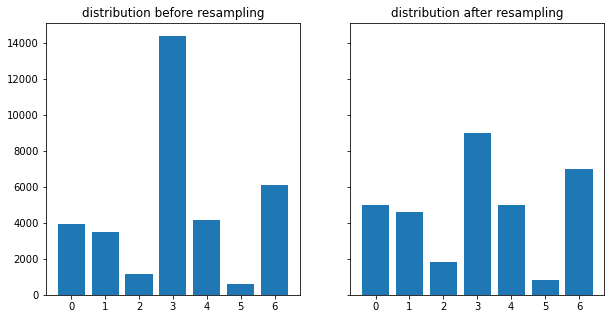

In [106]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey = True)


ax[0].bar(count_before_resample.keys(), count_before_resample.values())
ax[0].yticks = np.arange(0,8000,1000)
ax[0].set_title('distribution before resampling')
#plt.subplot(1,2,2)
ax[1].bar(count_after_resample.keys(), count_after_resample.values())
ax[1].yticks = np.arange(0,8000,1000)
plt.title('distribution after resampling')
plt.show()

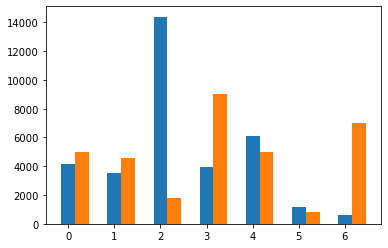

In [107]:
locs1 = np.arange(0,7,1)
locs2 = np.arange(0.3,7.3,1)

p1 = plt.bar(locs1,  count_before_resample.values(), width = 0.3, label = 'pre sampling')
p2 = plt.bar(locs2,  count_after_resample.values(), width = 0.3,label = 'post sampling')

plt.show()

We now have a less imbalanced class distribution in our training data

### Modeling with the new distribution

In [71]:
lr.fit(X_tr, y_tr)

LogisticRegression()

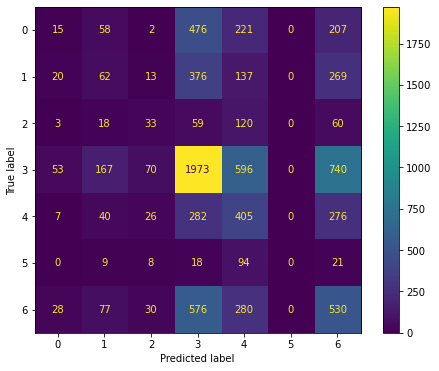

In [72]:
plot_cm(lr)

In [73]:
ez_mets(lr)

Recall  0.3569485511531638
Precision  0.3304679147500123
AUC-ROC-Score  0.690226714851177


In [74]:
ez_model(lr, store = True)

LogisticRegression()
accuracy  0.3569485511531638
Recall  0.3569485511531638
Precision  0.3304679147500123
f1  0.3330121340139711
AUC-ROC-Score  0.690226714851177


RandomForestClassifier()
accuracy  0.36581904198698995
Recall  0.36581904198698995
Precision  0.32021871346169545
f1  0.3352329502269156
AUC-ROC-Score  0.6569990915542275


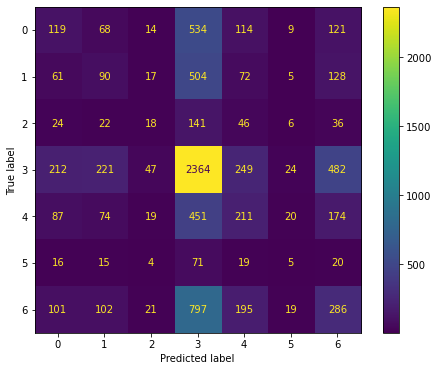

In [75]:
ez_model(rf, plot = True, store = True, fit = True)

GradientBoostingClassifier()
accuracy  0.4358367829686576
Recall  0.4358367829686576
Precision  0.35798477594163086
f1  0.31460025947998804
AUC-ROC-Score  0.7283790206471588


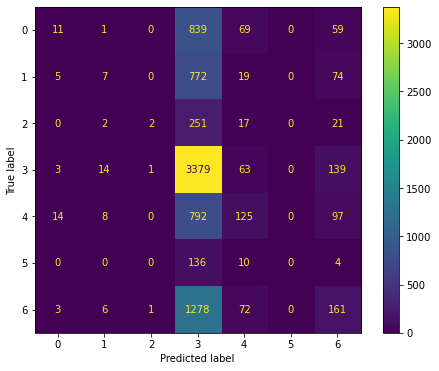

In [76]:
ez_model(gb, plot = True, store = True, fit = True)

In [111]:
lr2 = LogisticRegression()

In [113]:
lr2.fit(X_tr,y_tr)

LogisticRegression()

LogisticRegression()
accuracy  0.35931401537551744
Recall  0.35931401537551744
Precision  0.33253329400878656
f1  0.33517667283778063
AUC-ROC-Score  0.690102835381765


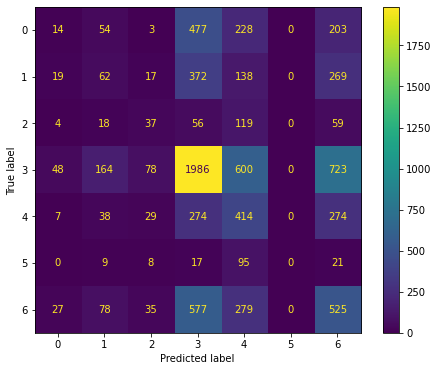

In [114]:
ez_model(lr2, metrics=True, plot= True)

In [120]:
rf2 = RandomForestClassifier(n_estimators = 1000)
rf2.fit(X_tr,y_tr)

RandomForestClassifier(n_estimators=1000)

RandomForestClassifier(n_estimators=1000)
accuracy  0.32808988764044944
Recall  0.32808988764044944
Precision  0.3330193847305942
f1  0.329636474078963
AUC-ROC-Score  0.6662290969066388


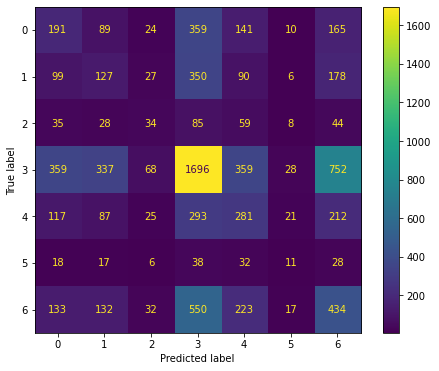

In [121]:
ez_model(rf2, metrics = True, plot = True)

accuracy  0.3243744207599629
f1  0.32824110080302477
Recall  0.3243744207599629
Precision  0.334579063550648
AUC-ROC-Score  0.6453276060209986


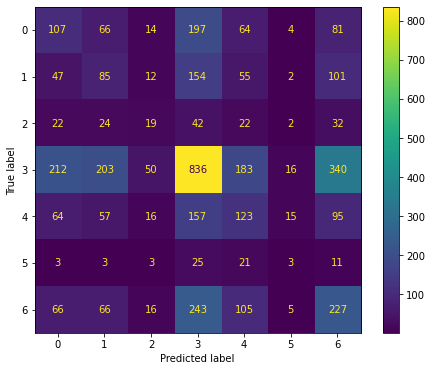

In [73]:
plot_cm(rf)
ez_mets(rf)

GradientBoostingClassifier()
accuracy  0.39053814311058543
Recall  0.39053814311058543
Precision  0.3468848052195333
f1  0.35475381319348265
AUC-ROC-Score  0.725698703140709


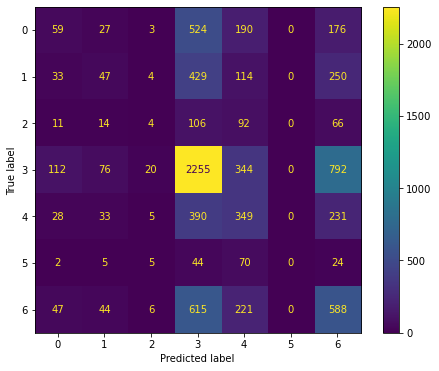

In [119]:
gb3 = GradientBoostingClassifier()
gb3.fit(X_tr, y_tr)
ez_model(gb3, metrics = True, plot = True)

LogisticRegression()
accuracy  0.4254287403903016
Recall  0.4254287403903016
Precision  0.2822530797256812
f1  0.29082936157655415
AUC-ROC-Score  0.6913697727589802


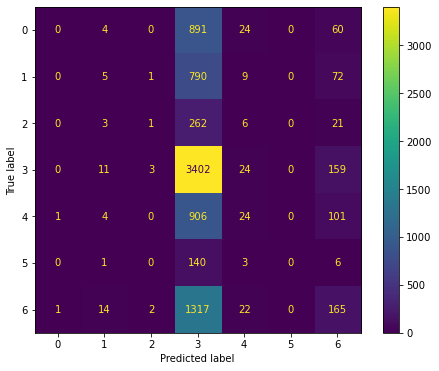

In [109]:
ez_model(lr, metrics = True, fit = True, plot = True)

In [117]:
steps = [('over', SMOTE()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('over', SMOTE()), ('model', LogisticRegression())])

Pipeline(steps=[('over', SMOTE()), ('model', LogisticRegression())])
accuracy  0.24671791839148433
Recall  0.24671791839148433
Precision  0.379344373504267
f1  0.27464164916003037
AUC-ROC-Score  0.6801354997635515


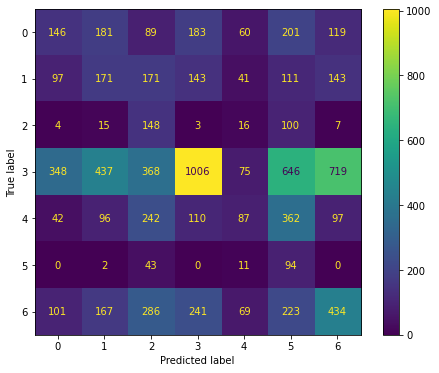

In [118]:
ez_model(pipeline,metrics = True, plot = True)

In [77]:
over = SMOTE()
under = RandomUnderSampler()
steps = [('over', over), ('under', under), ('model', RandomForestClassifier())]
#from sklearn.ensemble import RandomForestClassifier
#steps = [ ('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

In [78]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 12)
scores = cross_val_score(pipeline, X_s, y1, scoring = 'accuracy',n_jobs = -2)
print(scores)

[0.30305839 0.31441149 0.32622799 0.31765524 0.32738647]


## Other hyperparameter tuning code

Recall that the gradient boosting classifier had the best performance out of the box, but still wasn't much better than the dummy classifier. Many attempts were made to improve upon it (and the others) via hyperparameter tuning, but to no avail. Below is some of the code that was used. 

In [79]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
dpts = np.arange(3,25,3)
n_estimators = [50,100,200]
#my_grid = {'n_estimators': n_estimators,
#           'max_features': max_features,
#           'min_samples_split': min_samples_split,
#           'min_samples_leaf': min_samples_leaf,
#           'bootstrap': bootstrap}
grid_gb = {'max_depth':dpts, 'n_estimators' : n_estimators}
gb = GradientBoostingClassifier()
CV_gb = RandomizedSearchCV(estimator=gb, param_distributions=grid_gb, cv= 5, n_jobs = -2 , verbose = -2)
CV_gb.fit(X_train, y_train)
print(CV_gb.best_params_)


In [ ]:
CV_gb.best_params_

In [ ]:
CV_gb.cv_results_

In [ ]:
plot_cm(CV_gb)

In [ ]:
ez_mets(CV_gb)

In [ ]:
CV_gb2.cv_results_

In [ ]:
plot_cm(CV_gb2)

In [ ]:
ez_mets(CV_gb2)

### Storing this model

In [ ]:
# From the guided capstone project file
best_model = CV_gb2.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [ ]:
# save the model
modelpath = '../models'
save_file(best_model, 'pitch_prediction.pkl', modelpath)